<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Geographic-coordinate-systems" data-toc-modified-id="Geographic-coordinate-systems-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Geographic coordinate systems</a></span><ul class="toc-item"><li><span><a href="#Basic-points" data-toc-modified-id="Basic-points-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Basic points</a></span></li><li><span><a href="#An-example" data-toc-modified-id="An-example-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>An example</a></span></li></ul></li><li><span><a href="#Map-projections" data-toc-modified-id="Map-projections-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Map projections</a></span><ul class="toc-item"><li><span><a href="#plotting-Vancouver-on-a-map" data-toc-modified-id="plotting-Vancouver-on-a-map-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>plotting Vancouver on a map</a></span><ul class="toc-item"><li><span><a href="#Step-1:-Use-cartopy-to-make-a-LAEA-map-of-BC-including-Vancouver." data-toc-modified-id="Step-1:-Use-cartopy-to-make-a-LAEA-map-of-BC-including-Vancouver.-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Step 1: Use <a href="http://scitools.org.uk/cartopy/docs/latest/index.html" target="_blank">cartopy</a> to make a LAEA map of BC including Vancouver.</a></span></li></ul></li><li><span><a href="#zoom-in-on-vancouver" data-toc-modified-id="zoom-in-on-vancouver-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>zoom in on vancouver</a></span></li><li><span><a href="#Use-transform_point" data-toc-modified-id="Use-transform_point-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Use transform_point</a></span></li><li><span><a href="#Step-2:--Put-the-corners-of-a-modis-granule-on-the-map.--Use-this-2013.220.2105-granule" data-toc-modified-id="Step-2:--Put-the-corners-of-a-modis-granule-on-the-map.--Use-this-2013.220.2105-granule-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Step 2:  Put the corners of a modis granule on the map.  Use this 2013.220.2105 granule</a></span></li></ul></li></ul></div>

# Geographic coordinate systems

The pamphlet:

[Understanding map projections](https://clouds.eos.ubc.ca/~phil/courses/eosc582/downloads/understanding_map_projections.pdf)

Introduces geographic coordinate systems in Chapter 1.  They solve the problem of how to locate yourself on the earth's surface in three dimensions.  They specify an angular measure of units, a prime meridian, a spheroid and a datam (see chapter 1).

## Basic points

We need to define two fundamental things:

1.  A "[datum](https://www.maptools.com/tutorials/map_datum)"  (called a "globe" in cartopy) that gives the three dimensional shape of the earth (and other things)

1.  A "[projection](https://en.wikipedia.org/wiki/List_of_map_projections)" that maps a point on the earth's surface onto an x-y coordinate system to make a 2-dimensional plot.

1.  Our mapping module is called [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html).  Internally, it uses projection code in [pyproj](https://github.com/jswhit/pyproj), which in turn is a wrapper around C code called 
[proj4](https://proj4.org/usage/projections.html)

## An example

The [Equal Area Scalable Earth Grid](https://nsidc.org/data/ease)

1. Datum: The original EASE grid assumed a spherical earth with a radius of 6371.228 km.  [EASE-2](https://nsidc.org/data/ease/versions.html) uses a datum called [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System)

1. Both EASE and EASE-2 use the [Lambert Azimuthal Equal Area](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) or LAEA 

# Map projections

Chapter 2 describes map projections.  We will generally be using the LAEA projection for individual Modis granules.  

## plotting Vancouver on a map


### Step 1: Use [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html) to make a LAEA map of BC including Vancouver.  

**The cell below uses [context.py](https://github.com/phaustin/a301_code/blob/master/notebooks/context.py) to find
     the path to data_dir.  It is held in the variable context.data_dir**

In [16]:
from context import data_dir
from a301.utils.data_read import download
read_data=False
if read_data:
    filename='MYD021KM.A2013222.2105.061.2018047235850.hdf'
    download(filename)
    local_file = Path.cwd() / Path(filename)
    to_file = data_dir / Path(filename)
    local_file.rename(to_file)  

**This cell sets up the datum and the LAEA projection, with the tangent point at the North Pole and the central meridian at -90 degrees west of Greenwich**

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
from pathlib import Path
import pprint
import numpy as np
#
# Datum: radius of the earth in meters
#
radius=6371228

#
# vancouver longitude, latitude indegrees
#
van_lon,van_lat = [-123.1207,49.2827]
#
# use a simple sphere as the datum
#
globe = ccrs.Globe(ellipse=None, semimajor_axis=radius, 
                   semiminor_axis=radius)
#
# set up 
#
projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90,
                                          central_longitude= -90,globe=globe)
print(f'pro4 program params: {projection.proj4_params}')

**Use matplotlib to draw the map and add a coastline**

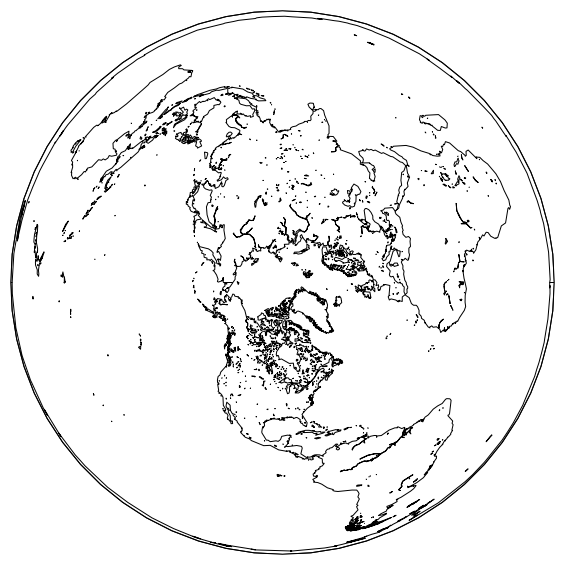

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(10,10),
                          subplot_kw={'projection': projection})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale='coarse', levels=[1,2,3]));

##  zoom in on vancouver

The next step is to pick an bounding box in map coordinates (the "extent") to limit the map area

In [15]:
#
# pick a bounding box in map coordinates
# (we'll see how to get cornerx below)
#
cornerx=9024309  #meters, from NL.hdr
cornery=cornerx
newcornerx=cornerx/2.
newcornery=newcornerx

## Use transform_point

This is how we put Vancouver (in lon,lat coords) on the map (in x,y coords)

-2422235.2316723852 -3712768.5862524547


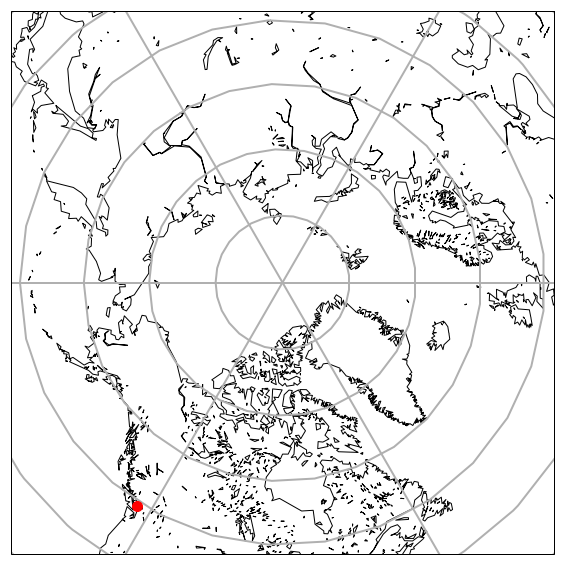

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,10),
                       subplot_kw={'projection': projection})
#
# clip with 0,0 in the center:  [xleft, xright, ybot, ytop]
#
new_extent=[-newcornerx,newcornerx,-newcornery,newcornery]
ax.set_extent(new_extent,projection)
#
# the simple lon,lat projection is called "geodetic"
#
geodetic = ccrs.Geodetic()
van_x,van_y=projection.transform_point(van_lon,van_lat,geodetic)
ax.plot(van_x,van_y,'ro',markersize=10);
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale='coarse', levels=[1,2,3]));
print(van_x,van_y)

## Step 2:  Put the corners of a modis granule on the map.  Use this 2013.220.2105 granule

<img src="images/myd2105.jpg" width=400>



**The cell below uses 

In [ ]:
%matplotlib inline
from a301.scripts.modismeta_read import parseMeta
import context
data_dir=Path(context.data_dir)
modis_file=list(data_dir.glob("MYD02*2105*hdf"))[0]
modis_dict=parseMeta(modis_file)

{'daynight': 'Day',
 'equatordate': '2013-08-10 UCT',
 'equatortime': '21:45:48 UCT',
 'filename': 'MYD021KM.A2013222.2105.061.2018047235850.hdf',
 'lat_0': 39.59910106367865,
 'lat_list': array([32.13645208, 28.68737463, 45.73346986, 50.51082749]),
 'lon_0': -121.4048713497655,
 'lon_list': array([-104.7708939 , -129.00539789, -138.0388488 , -107.00171861]),
 'max_lat': 50.5108274923951,
 'max_lon': -104.770893902908,
 'min_lat': 28.6873746349622,
 'min_lon': -138.038848796623,
 'nasaProductionDate': '2018-02-16 UCT',
 'orbit': '59949',
 'startdate': '2013-08-10 UCT',
 'starttime': '21:05:00 UCT',
 'stopdate': '2013-08-10 UCT',
 'stoptime': '21:10:00 UCT'}


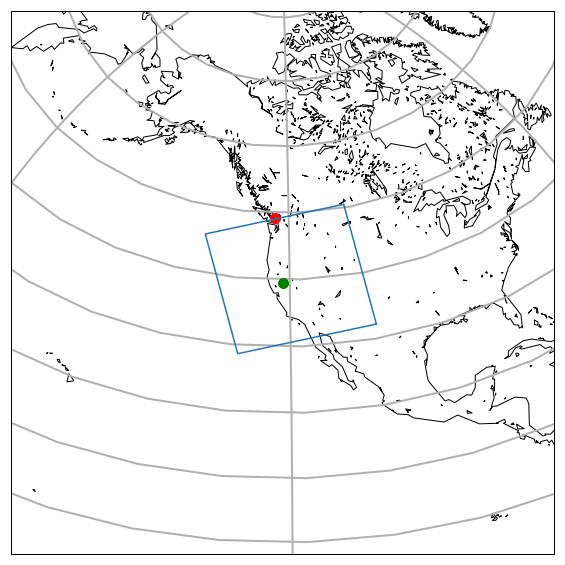

In [13]:
pprint.pprint(modis_dict)
projection=ccrs.LambertAzimuthalEqualArea(central_latitude=modis_dict['lat_0'],
                                          central_longitude= modis_dict['lon_0'],globe=globe)
center_point = projection.transform_point(modis_dict['lon_0'],modis_dict['lat_0'],geodetic)
top_right = projection.transform_point(modis_dict['max_lon'],modis_dict['max_lat'],geodetic)
bottom_left = projection.transform_point(modis_dict['min_lon'],modis_dict['min_lat'],geodetic)
extent=[bottom_left[0],top_right[0],bottom_left[1],top_right[1]]
van_x,van_y=projection.transform_point(van_lon,van_lat,geodetic)

fig, ax = plt.subplots(1, 1, figsize=(10,10),
                       subplot_kw={'projection': projection})
ax.set_extent(new_extent,projection)
ax.plot(van_x,van_y,'ro',markersize=10);
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale='coarse', levels=[1,2,3]));
out=projection.transform_points(geodetic,np.array(modis_dict['lon_list']),np.array(modis_dict['lat_list']))
xcoords = np.append(out[:,0],out[0,0])
ycoords = np.append(out[:,1],out[0,1])
ax.plot(xcoords, ycoords);
ax.plot(center_point[0],center_point[1],'go',markersize=10)